In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Random clustered BA graph

In [2]:
n = 200
m = 2
seed = 0
G = nx.generators.random_graphs.powerlaw_cluster_graph(n,m,p=0.2,seed=seed)

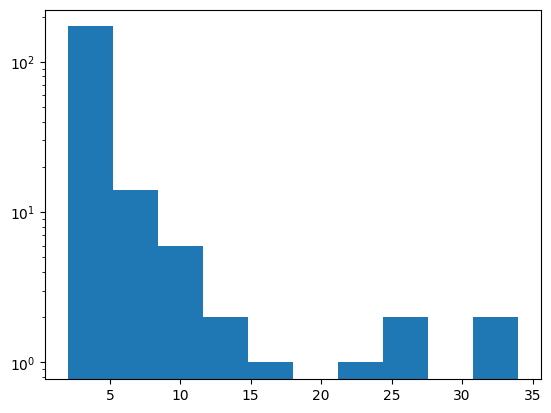

In [3]:
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees,log=True)
plt.show()


In [4]:
#we color every node with degree > 20 with red
#the node label will be the node degree
for node in G.nodes():
    G.nodes[node]['node_label']=str(G.degree(node))
    if G.degree(node) > 20:
        G.nodes[node]['node_color']='red'
    else:
        G.nodes[node]['node_color']='grey'

#export for yED
nx.write_graphml(G, 'BA_random.graphml')

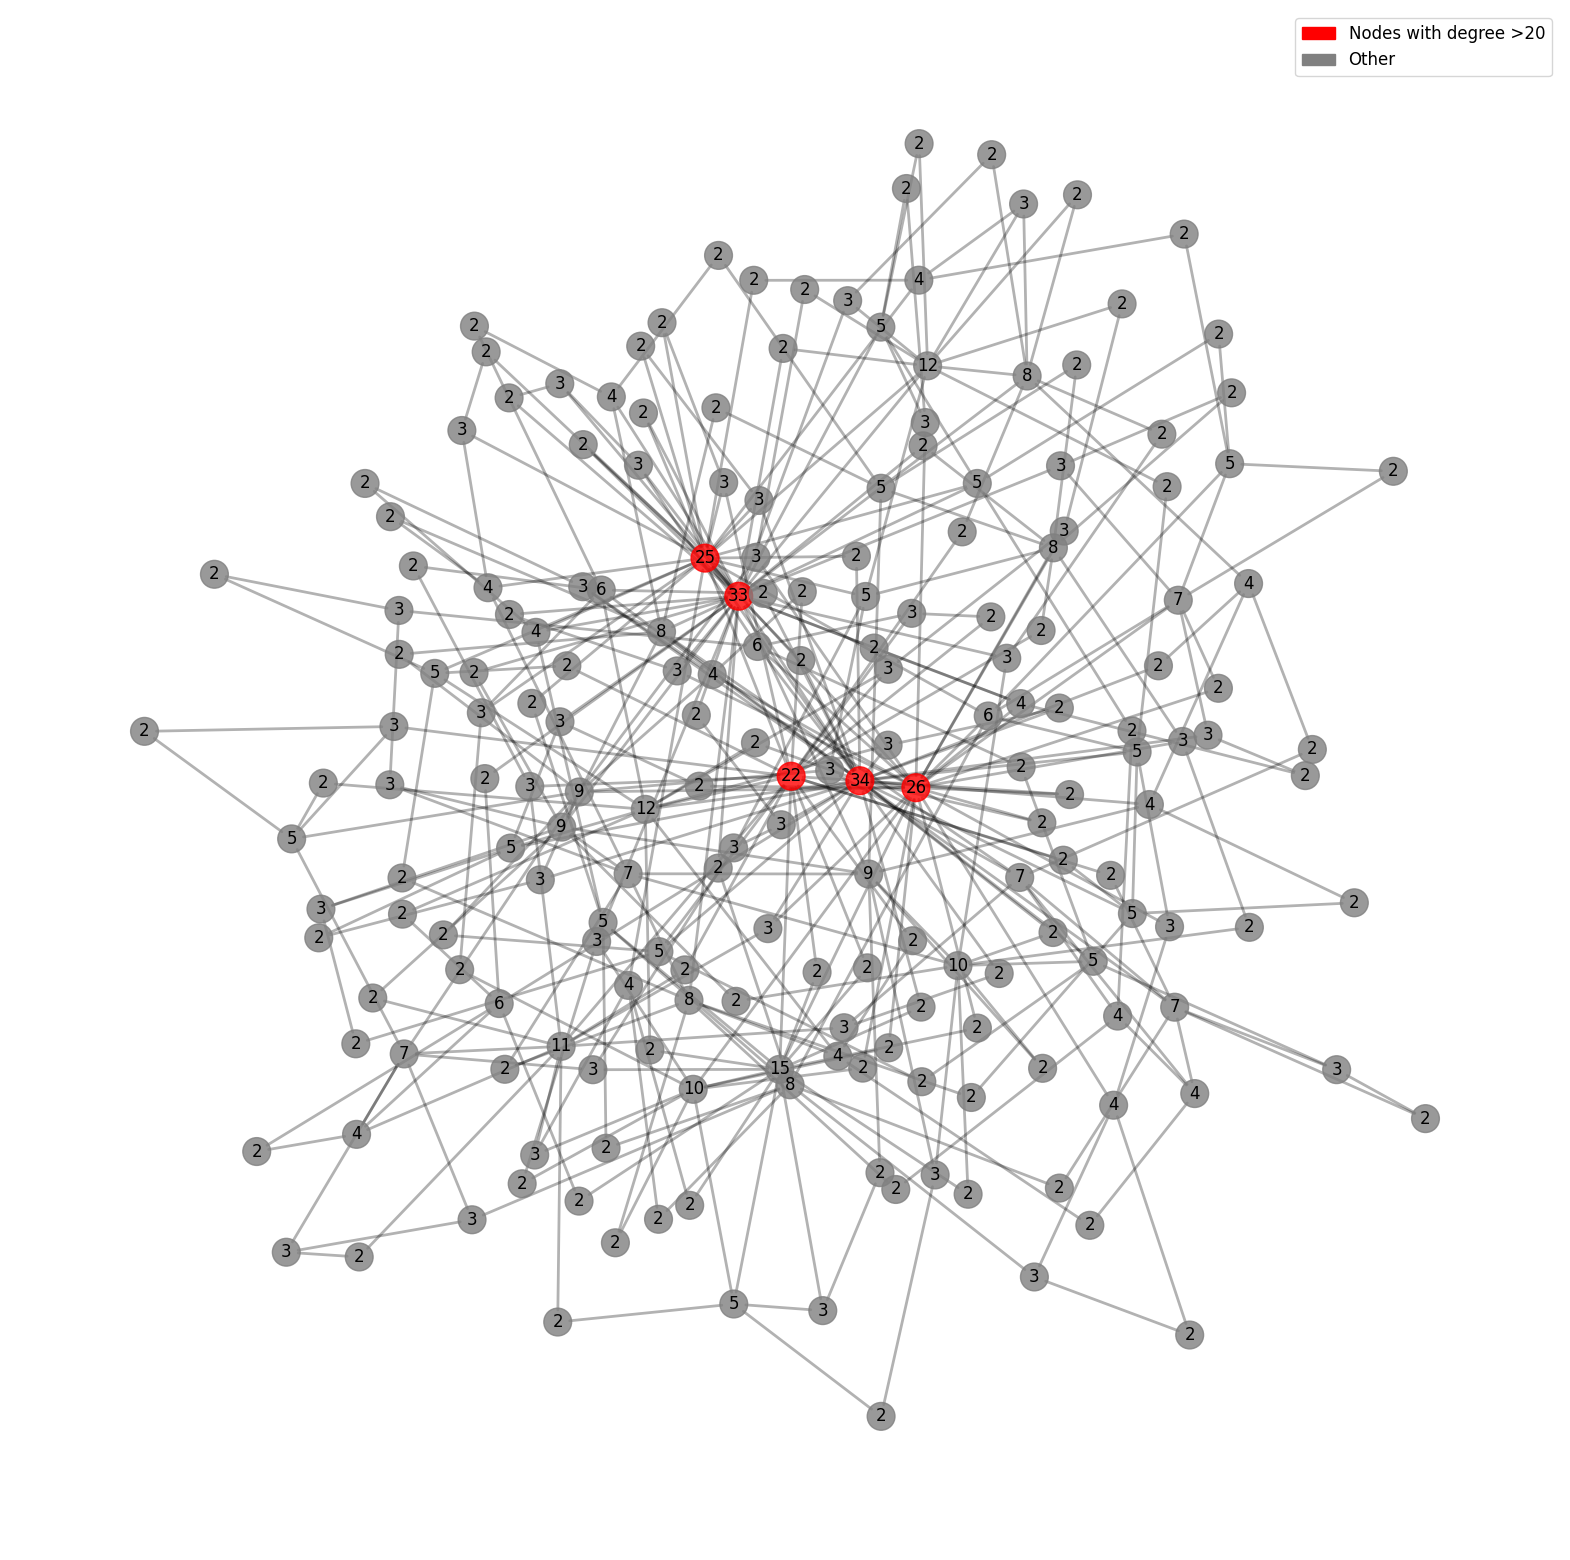

In [5]:
#plotting with networkx and matplotlib

plt.figure(figsize=(20,20))

node_labels = dict(G.nodes('node_label'))
node_alpha = 0.8
edge_weights = 2
edge_label_font_size=12
node_label_font_size=12
edge_alpha=0.3
edge_labels={}
node_colors = dict(G.nodes('node_color'))
node_size = 400

pos=nx.layout.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=edge_alpha,width=edge_weights,arrows=True,arrowsize=30)
el = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_size=edge_label_font_size)
lc  = nx.draw_networkx_labels(G,pos,node_labels,font_size=node_label_font_size)
nc = nx.draw_networkx_nodes(G, pos,alpha=node_alpha,node_color=node_colors.values(), node_size=node_size)
plt.axis('off')

#LEGEND
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Nodes with degree >20')
grey_patch = mpatches.Patch(color='grey', label='Other')
plt.legend(fontsize=12,handles=[red_patch,grey_patch])
#plt.savefig(plot_name+'.png')
#plt.savefig(plot_name+'.pdf')
plt.show()

# Real network: Subgraph of HUBRIS (PPI)- COPD GWAS genes protein products and the new paths connecting them to HHIP via the newly identified edges

Github of Hubris: https://github.com/deriteidavid/hubris <br>
Zenodo: https://doi.org/10.5281/zenodo.14604608 <br>
Human Molecular Genetics, ddaf016, https://doi.org/10.1093/hmg/ddaf016 

In [6]:
import hubris_functions as hf

G_hubris = nx.read_gml('G_hubris_lcc.gml')

#For this graph we use the union of 16HBE and IMR90 interactions with CRAPome controls and no RNASeq filtering
experiment = 'union'

copd_gwas_genes=['HHIP',
                 'FAM13A',
                 'IREB2',
                 'DSP',
                 'AGER',
                 'MFAP2',
                 'FBLN5',
                 'NPNT',
                 'FBXO38',
                 'SFTPD',
                 'TET2',
                 'TGFB2', 
                 'MMP12',
                 'MMP1']
                 
#we read in the experimental edges and add them to the network
df_all_HHIP_links=pd.read_excel('all_significant_links_HHIP.xlsx')
target_proteins=list(df_all_HHIP_links[(df_all_HHIP_links['crapome_16HBE_06']==1) | (df_all_HHIP_links['crapome_16HBE_11']==1) | (df_all_HHIP_links['crapome_IMR90_06']==1)]['bait_gene_symbol'])

new_targets_list=[]
new_edges=[]
new_edges+=list(zip(['HHIP' for i in range(len(target_proteins))], target_proteins))
print(new_edges)

G_hubris_extended=G_hubris.copy()
G_hubris_extended.add_edges_from(new_edges)

G_induced_hubris,hubris_sp_count_and_len=hf.induced_graph(G_hubris,'HHIP', copd_gwas_genes)
G_induced_hubris_extended,hubris_extended_sp_count_and_len=hf.induced_graph(G_hubris_extended,'HHIP', copd_gwas_genes)

G_new_paths=G_hubris_extended.subgraph(list(set(G_induced_hubris_extended.nodes())-set(G_induced_hubris.nodes()))+copd_gwas_genes+target_proteins).copy()
print(len(max(nx.connected_components(G_new_paths), key=len)))
print(G_new_paths.number_of_nodes())
G_new_paths.remove_edges_from(nx.selfloop_edges(G_new_paths))
for node in G_new_paths.nodes():
    G_new_paths.nodes[node]['label']=node
    if node in copd_gwas_genes:
        G_new_paths.nodes[node]['type']='gwas'
    elif node in target_proteins:
        G_new_paths.nodes[node]['type']='new_interactor'
    else:
        G_new_paths.nodes[node]['type']='hubris_node'

for e in G_new_paths.edges():
    
    if 'db' in G_new_paths.edges[e].keys():
        db=G_new_paths.edges[e]['db']
        G_new_paths.edges[e]['db']=str(db)

#export for yED
nx.write_graphml(G_new_paths,'G_new_paths.graphml') 

[('HHIP', 'HHIP'), ('HHIP', 'UGGT1'), ('HHIP', 'CALM1'), ('HHIP', 'CAVIN1'), ('HHIP', 'TMED2'), ('HHIP', 'TMED10'), ('HHIP', 'ASPH'), ('HHIP', 'MMP9'), ('HHIP', 'GORASP2'), ('HHIP', 'MAP4'), ('HHIP', 'EIF2S2'), ('HHIP', 'THBS1'), ('HHIP', 'RRBP1'), ('HHIP', 'RPLP0'), ('HHIP', 'HMGN1'), ('HHIP', 'TP53'), ('HHIP', 'TMED7'), ('HHIP', 'GREM1')]


14it [00:05,  2.55it/s]
14it [00:05,  2.41it/s]

99
99


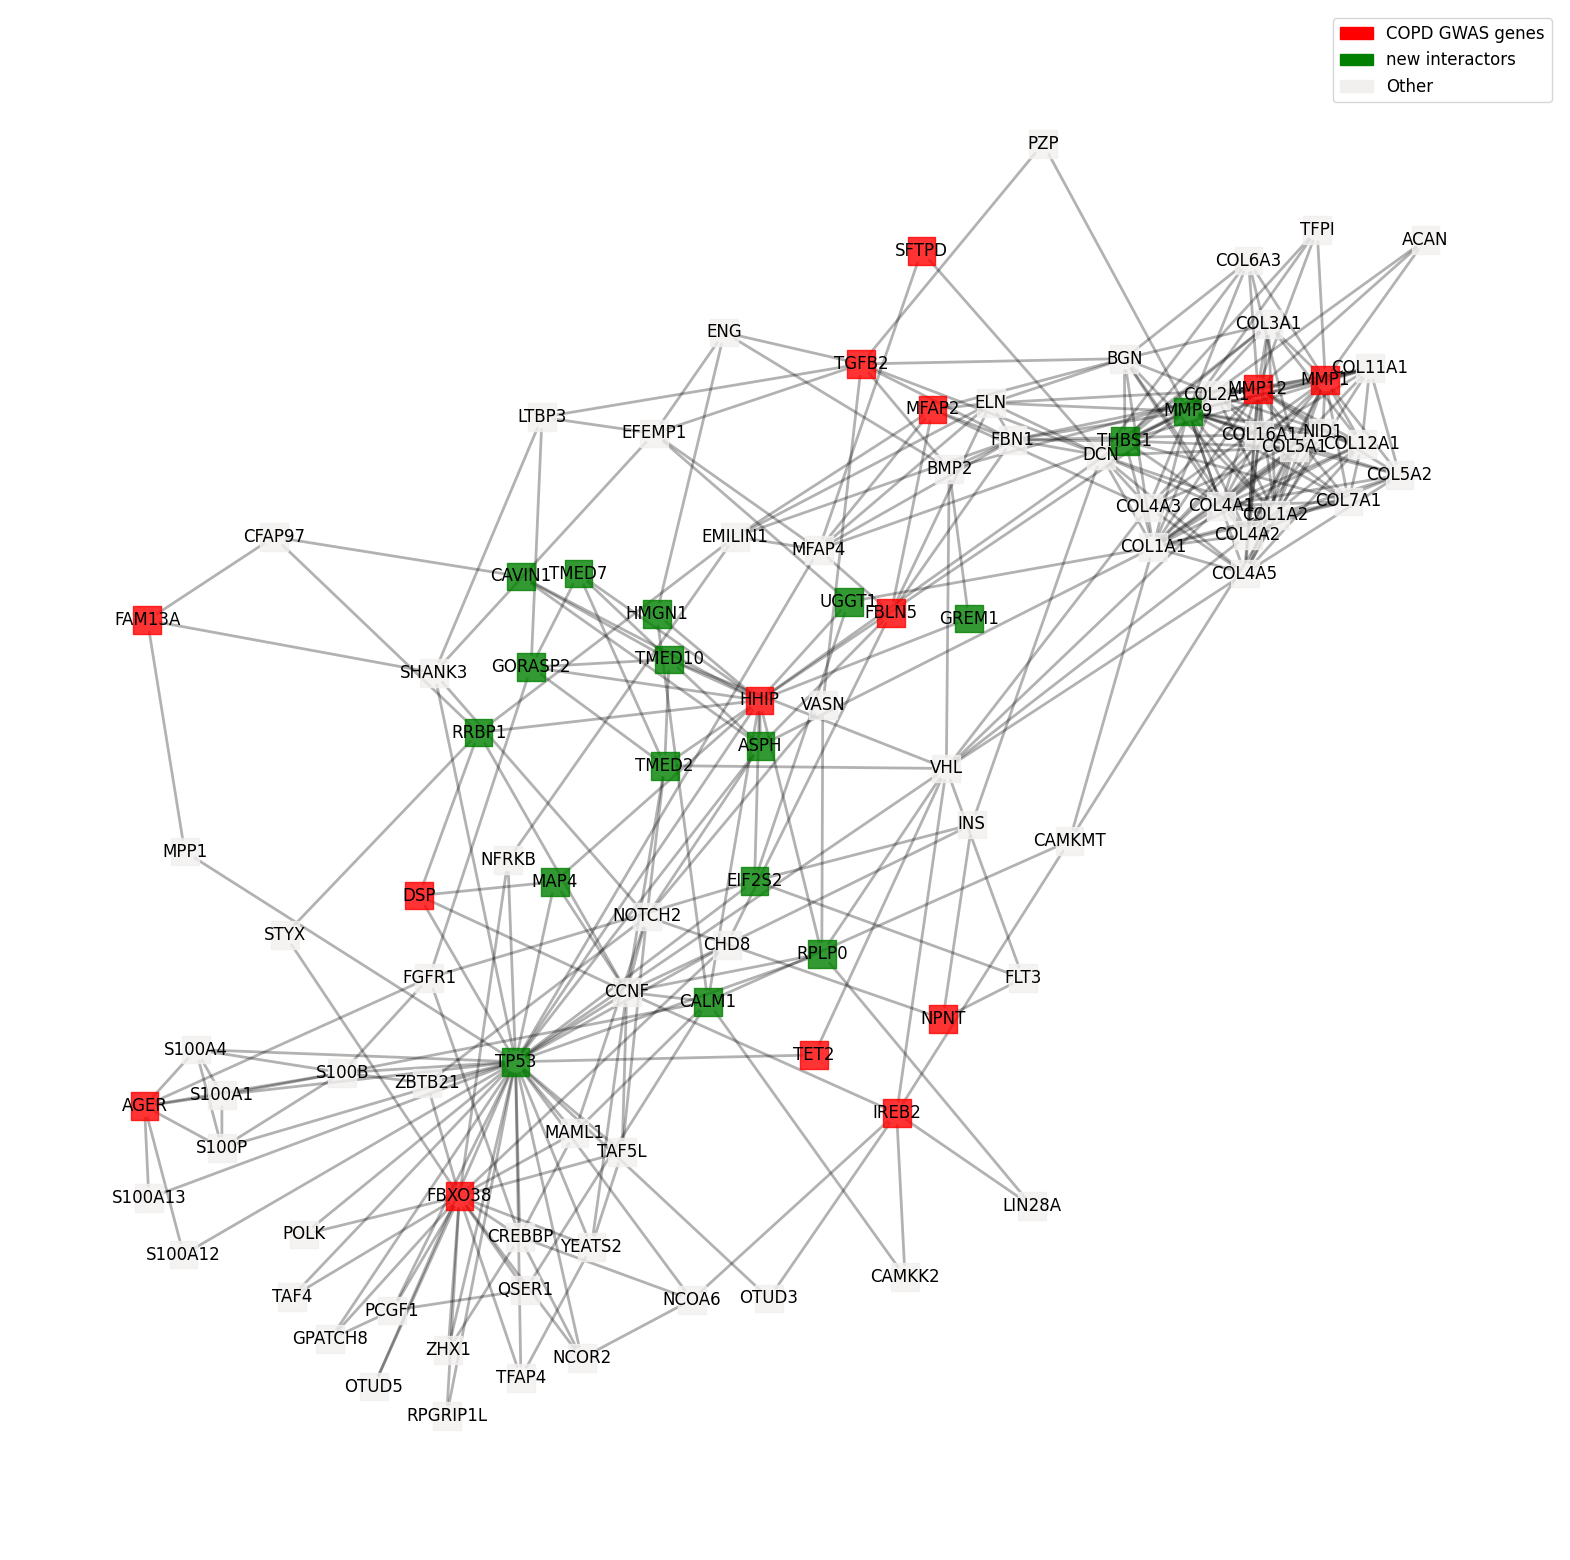

In [7]:
#plotting with networkx and matplotlib

G=G_new_paths.copy()

node_colors=[]
for node in G.nodes():
    if G.nodes[node]['type']=='gwas':
        node_colors.append('red')
    elif G.nodes[node]['type']=='new_interactor':
        node_colors.append('green')
    else:
        node_colors.append('#F2F0EF')


plt.figure(figsize=(20,20))

node_labels = dict(G.nodes('label'))
node_alpha = 0.8
edge_weights = 2
edge_label_font_size=12
node_label_font_size=12
edge_alpha=0.3
edge_labels={}
node_size = 400

pos=nx.layout.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=edge_alpha,width=edge_weights,arrows=True,arrowsize=30)
el = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_size=edge_label_font_size)
lc  = nx.draw_networkx_labels(G,pos,node_labels,font_size=node_label_font_size)
nc = nx.draw_networkx_nodes(G, pos,alpha=node_alpha,node_color=node_colors, node_size=node_size,node_shape = 's')
plt.axis('off')

#LEGEND
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='COPD GWAS genes')
green_patch = mpatches.Patch(color='green', label='new interactors')
grey_patch = mpatches.Patch(color='#F2F0EF', label='Other')
plt.legend(fontsize=12,handles=[red_patch,green_patch,grey_patch])
#plt.savefig(plot_name+'.png')
#plt.savefig(plot_name+'.pdf')
plt.show()